## Reweighting of two 2d gaussians with Boosted Decision Trees

The following demonstates the multivariate reweighting. The task is to reweight a 2d gaussian with no correlation between feature1 and feature2 such that it fits a 2d gaussian weher these features are correlated.

This notebook requires the ml_hep library:
pip install hep_ml

For documentation and other interesting stuff: https://arogozhnikov.github.io/hep_ml/

Explanation of the reweighting algorithm:
http://arogozhnikov.github.io/2015/10/09/gradient-boosted-reweighter.html

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import numpy as np
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore') #suppress deprecation warnings

## Create data
We create two 2d data sets that are sampled from gaussians. One with a correlation between the features the other without.


In [8]:
mean1, cov1, n_samples1 = np.array([0.,0.]), np.array([[3,0.0],[0.0,2]]), 200000
data1=np.random.multivariate_normal(mean1,cov1,size=n_samples1)
x1=data1[:,0]
y1=data1[:,1]
mean2, cov2, n_samples2 = np.array([0.,0.]), np.array([[3,1.8],[1.8,2]]), 200000
data2=np.random.multivariate_normal(mean2,cov2,size=n_samples2)
x2=data2[:,0]
y2=data2[:,1]

n=300 #number of data points to be plotted for scatter plots

Function for scatter plots that show weights as marker size

In [9]:
def make_plot(x1,y1,x2,y2,w1,w2):

    fig, axScatter = plt.subplots(figsize=(15, 15))

    #Plot data
    plt.rc('font',size=25)
    axScatter.scatter(x1,y1,color='b',s=100*w1-30,alpha=0.7)
    axScatter.scatter(x2,y2,color='g',s=100*w2-30,alpha=0.3)
    axScatter.set_aspect(1.)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.ylim(-8,8);
    plt.xlim(-8,8);

    #Create new axes for projections
    divider = make_axes_locatable(axScatter)
    axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
    axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)

    # make some labels invisible
    plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(),visible=False)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = np.max([np.max(np.fabs(x1)), np.max(np.fabs(y1))])
    lim = (int(xymax/binwidth) + 1)*binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x1,color='b', bins=bins, alpha=0.5)
    axHisty.hist(y1,color='b', bins=bins,alpha=0.5, orientation='horizontal')
    axHistx.hist(x2,color='g', bins=bins,alpha=0.5)
    axHisty.hist(y2,color='g', bins=bins,alpha=0.5, orientation='horizontal')

    # the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
    # thus there is no need to manually adjust the xlim and ylim of these
    # axis.

    histTicks = np.arange(0,0,100)
    #axHistx.axis["bottom"].major_ticklabels.set_visible(False)
    for tl in axHistx.get_xticklabels():
        tl.set_visible(False)
    axHistx.set_yticks(histTicks)

    #axHisty.axis["left"].major_ticklabels.set_visible(False)
    for tl in axHisty.get_yticklabels():
        tl.set_visible(False)
    axHisty.set_xticks(histTicks)

    #axScatter.legend(loc='upper left')
    #plt.title('Multivariate Guassians',y=1.2,x=-2.5,fontsize=20)
    plt.draw()
    plt.show() 

Plot dataset with all weights set to 1.

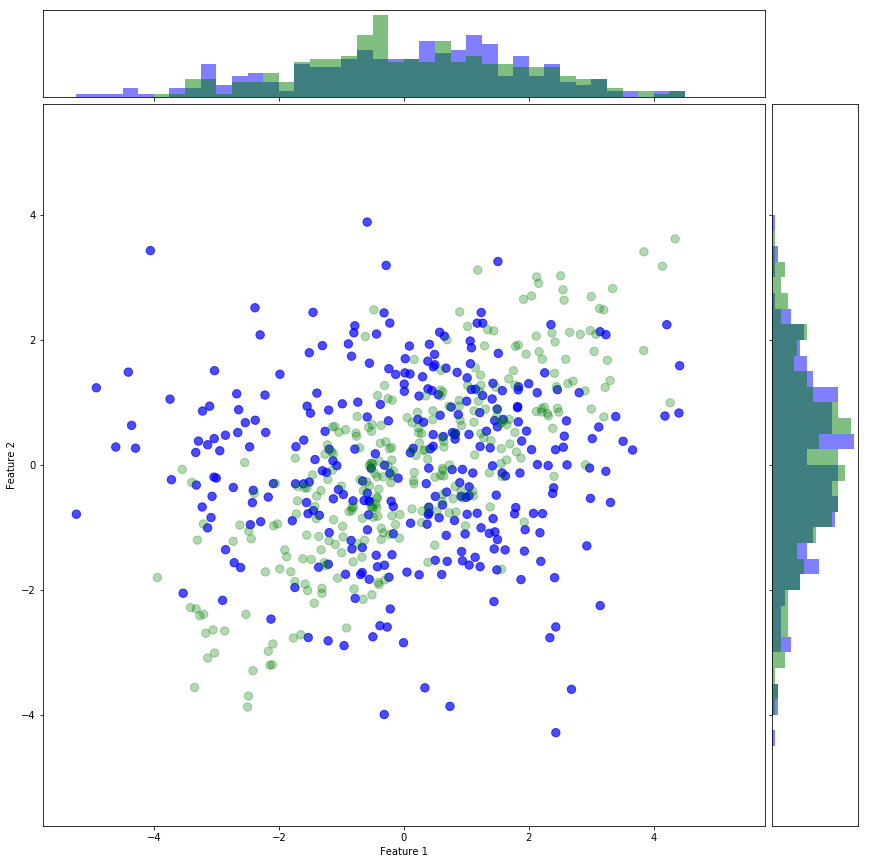

In [10]:
w1=np.ones(len(x1))
w2=np.ones(len(x2))

make_plot(x1[:n],y1[:n],x2[:n],y2[:n],w1[:n],w2[:n])

Train a reweighter fit function. First argument is the dataset that shall be adapted to the dataset in the second argument.

In [11]:
from hep_ml.reweight import GBReweighter
reweighter = GBReweighter(n_estimators=3, max_depth=8, learning_rate=0.9, min_samples_leaf = 100)

data1=np.column_stack((x1,y1))
data2=np.column_stack((x2,y2))

reweighter.fit(data1, data2)

GBReweighter(gb_args={}, learning_rate=0.9, max_depth=8, min_samples_leaf=100,
       n_estimators=3)

Let the reweighter predict the weights for the dataset that shall be reweighted.

Note: in a real application this would be bad practice! As in normal classification, also in reweighting one should evaluate the algorithm only on data that was not seen during training.

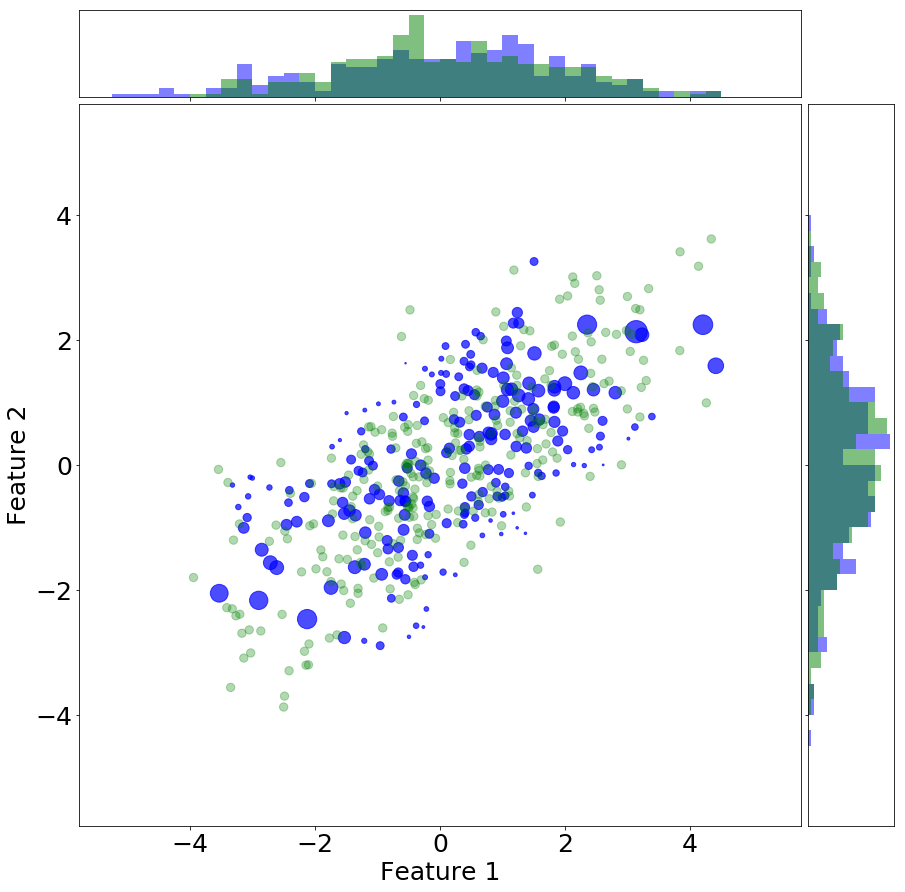

<function matplotlib.pyplot.show>

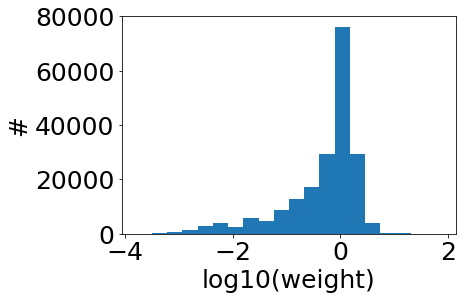

In [12]:
w1 = reweighter.predict_weights(data1)

make_plot(x1[:n],y1[:n],x2[:n],y2[:n],w1[:n],w2[:n])
plt.hist(np.log10(w1),bins=20)
plt.xlabel('log10(weight)')
plt.ylabel('#')
plt.show